# Final Project University of Nottingham Final Exam Scheduling

### Team members: Kien Le, Jenny Nguyen, Dionne Phan
### Instructor: Dr. Bonnifonte

## I - Introduction and motivation

During final exam season (including the time when we wrote this report), it is common to see students expressing stress and frustration about their tightly packed schedules. As one student shared, "My exam schedule is terrible. I have to take three exams in a row from morning to night, and then turn in my final project at 10 a.m. the next morning" (Kien during his sophomore year). Experiences like this are common at Denison, and they highlight a central concern: **why do exam schedules end up being so stressful, and could they be designed more fairly?**

This project addresses that concern by examining the principles behind final exam schedules and the challenges that limit how balanced they can be. Our goal is to understand the basic structure of the exam scheduling problem and determine whether seemingly "bad" schedules are the result of randomness, unavoidable constraints, or flaws in the scheduling model itself. While we initially hoped to analyze Denison data, that information was not available (and we know that another group had already conducted a similar project). Instead, we used the **University of Nottingham’s final exam schedule** as a representative dataset, since it reflects the typical constraints faced by universities—such as exam room capacity, overlapping student enrollments, departmental requirements, fixed exam periods, and other complex considerations.

From this dataset, we set out to answer four central research questions:

1. **What is the definition of a "good" exam schedule for students?**
2. **How can an exam schedule be constructed in a systematic and principled way?**
3. **What are the key bottlenecks or limiting factors that make exam scheduling difficult?**
4. **If we build a working scheduling model, how can it be applied or adapted to Denison’s exam system?**

Understanding these questions is valuable not only for students, but also for administrators responsible for producing exam schedules. Insights from this analysis may reveal whether better scheduling algorithms could lead to a better exam experiences, or whether certain bottlenecks are simply unavoidable.

This report is organized as follows. Section 2 presents the preliminaries, including our data sources, data-wrangling process, and the overall setup of the problem. Section 3 details the modeling steps we used to construct and evaluate exam schedules, followed by an analysis of the results. Finally, Section 4 discusses how our model could be applied to Denison’s exam scheduling system and concludes with the broader implications of our findings.

## II - Preliminaries

In this section, we introduce the data sources and structure of the dataset, outline the key objectives guiding our exam scheduling model, and describe our preprocessing steps and setup required for model construction,.

### a. Data Source and Structure

The [exam timetabling dataset](https://people.cs.nott.ac.uk/pszrq/data.htm) was obtained from the University of Nottingham and is publicly available for research purposes. It was originally introduced by Burke, Newall, and Weare (1996) in their foundational study on university examination scheduling and has since become a standard benchmark within the exam timetabling community. The dataset represents real scheduling data of the 1994 - 1995 academic year at the University of Nottingham and includes detailed information on students, courses, exams, and enrolments. In total, the dataset contains 800 exams across 46 departments, 7,896 students, and 33,997 enrollments—equivalent to an average of 4.3 exams per student and 42.5 students per exam. A key feature of the dataset is its global room-capacity constraint: in any given timeslot, the total number of students taking exams cannot exceed 1,550. The primary objective defined in the original study is to minimize the number of students assigned to two consecutive exams on the same day. A later extension expands the objective to also avoid consecutive overnight exams (Burke & Carter, 1998).

Because it is based on real institutional data, incorporates practical scheduling constraints, and defines clear optimization objectives, the University of Nottingham dataset provides a rigorous, transparent, and reproducible benchmark for evaluating exam scheduling models. The dataset is provided in text format and consists of four main files:

1. `students`: This file contains information on student enrollment in courses. It has two columns:
* Student code: a 10-character unique identifier for each student.
* Course code: the code of the course the student is enrolled in.

1. `exams`: This file provides details about each exam and consists of four columns:
* Exam code: a unique identifier for the exam.
* Course name: the name of the course associated with the exam.
* Exam duration: the length of the exam in minutes.
* Department code: the code of the department responsible for the exam.

1. `enrolments`: This file links the students and exams datasets. It contains two columns:
* Student code: the unique identifier for a student.
* Exam code: the unique identifier for an exam in which the student is enrolled.

1. `data`: This file is not a dataset but specifies the necessary conditions and constraints for course scheduling, such as room capacities, allowable time slots, and other parameters and special constraints required for constructing the timetable.

### b. Model objectives 

Our model is designed to achieve the following objectives:

1. **Construct a feasible exam schedule** that satisfies all required constraints, including room capacity limits, departmental requirements, and student enrollment.

2. **Minimize the number of students assigned to two consecutive exams on the same day**.

3. **Minimize overnight consecutive exams**, ensuring that students have adequate time to rest and prepare between assessment periods.

Given these three objectives, our modeling procedure is designed to achieve them step by step. This structured approach not only guides the construction of a feasible timetable but also helps identify the key bottlenecks and challenges that arise during exam scheduling. Taken together, these objectives aim to produce an exam schedule that is both logistically sound and student-centered, balancing operational feasibility with consideration for student well-being.

In [31]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from pathlib import Path
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, CustomJS, FixedTicker, LabelSet
from bokeh.layouts import column
output_notebook()

Loading BokehJS ...

In [32]:
ROOT = Path().resolve().parent

# load data
enrolments = pd.read_csv(ROOT / "converted-data" / "enrolments.csv")
exams = pd.read_csv(ROOT / "converted-data" / "exams.csv")
students = pd.read_csv(ROOT / "converted-data" / "students.csv")
coincidences = pd.read_csv(ROOT / "converted-data" / "coincidences.csv", index_col=0)
dates = pd.read_csv(ROOT / "converted-data" / "dates.csv")
times_expanded = pd.read_csv(ROOT / "converted-data" / "times_expanded.csv")
rooms = pd.read_csv(ROOT / "converted-data" / "rooms.csv")

In [33]:
# Helper function: convert exam duration from hh:mm to minutes
def parse_duration(time_str):
    h, m = time_str.split(":")
    return int(h) * 60 + int(m)

# Converting hours to mins
exams["duration_minutes"] = exams["duration"].apply(parse_duration)
times_expanded["timeslot"] = range(1, len(times_expanded) + 1)
times_expanded["slot_minutes"] = times_expanded["duration_hours"] * 60

In [34]:
# exam_list (list): the list of every exam
exam_list = exams["exam"].unique().tolist()

# duration (dict): the mapping from exam -> duration (mins)
duration = exams.set_index("exam")["duration_minutes"].to_dict()

# timeslots (list): the list of every timeslot
timeslots = times_expanded["timeslot"].tolist()

# slot_length (dict): the mapping from timeslots -> timeslots length (mins)
slot_length = times_expanded.set_index("timeslot")["slot_minutes"].to_dict()

# timeslot_day (dict): the mapping from timeslots -> day it occurs, in the form day_week
timeslot_day = {
    int(row["timeslot"]): f"{row['day']}_{row['week']}"
    for _, row in times_expanded.iterrows()
}

# days (list): the list of exam day, in the form day_week
days = list(set(timeslot_day.values()))

# day_to_timeslots (dict): the mapping from days -> list of timeslots in that day (sorted)
day_to_timeslots = {day: sorted([t for t, d in timeslot_day.items() if d == day]) for day in set(timeslot_day.values())}

# students_exams (dict): the mapping from students -> list of exams to take
students_exams = enrolments.groupby("student")["exam"].apply(list).to_dict()

# room_list (list): the list of every available room
room_list = rooms["room"].tolist()

# cap (dict): the mapping from room_list -> capacity of that room
cap = rooms.set_index("room")["capacity"].to_dict()

# size (dict): the mapping from exams -> number of students in that exam
size = (
    enrolments.groupby("exam")["student"]
    .nunique()
    .sort_values(ascending=False)
    .to_dict()
)

# groups (dict): the mapping from index -> lists of coincidences exam
groups = {
    k: ast.literal_eval(v) for k, v in zip(coincidences.index, coincidences["exams"])
}

# allow_pairs (list): the list of list of coincidences pairs
allowed_pairs = [
    (e1, e2)
    for exam_list_g in groups.values()
    for i, e1 in enumerate(exam_list_g)
    for e2 in exam_list_g[i + 1 :]
    for _ in range(2)
][::-1][::2][::-1] + [
    (e2, e1)
    for exam_list_g in groups.values()
    for i, e1 in enumerate(exam_list_g)
    for e2 in exam_list_g[i + 1 :]
]

# together_groups (list): the list of list of merge-able rooms
together_groups = [
    ["POPE-A13", "POPE-A14"],
    ["ART-LECTURE", "ART-SEMINAR"],
    ["SPORT-LGE1", "SPORT-LGE2"],
]

# special_exams (list): the list of exams with special rooms
special_exams = ["F12X02E1", "K1AHWAE2", "V13101E1"]

# super_rooms (list): the list of index of super rooms
super_rooms = list(range(len(together_groups)))

# super_capacity (dict): the mapping from super rooms index -> its capacity
super_capacity = {g: sum(cap[r] for r in together_groups[g]) for g in super_rooms}

# super_to_rooms (dict): the mapping from super rooms index -> the list of rooms that merge into
super_to_rooms = {g: together_groups[g] for g in super_rooms}

# time_order (list): list of available timeslot per day
time_order = ["9:00", "13:30", "16:30"]

# max_capacity (const): maximum students per timeslot
max_capacity = 1550

# time_to_y (dict): the mapping from time strings -> numeric Y values (for plotting)
time_to_y = {t: i + 1 for i, t in enumerate(time_order)}

# day_to_x (dict): the mapping from days -> numeric X values (for plotting)
day_to_x = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6}

In [35]:
def plot_source(schedule_df):
    """
    Convert the given schedule to plot source
    schedule_df: the schedule df with the columns [exam, day, week, start_time, duration_min, timeslot]
    Output: plot source for plotting
    """
    x_coords, y_coords, exam_texts, week_list = [], [], [], []

    for _, row in schedule_df.iterrows():
        day = row["day"]
        time = row["start_time"]
        week = row["week"]

        y_val = time_to_y[time] + 4 * (week - 1)
        x_coords.append(day_to_x[day])
        y_coords.append(y_val)
        exam_texts.append(row["exam"])
        week_list.append(week)

    student_counts = [size[e] for e in exam_texts]

    # Combine exams in same cell
    df_vis = pd.DataFrame(
        {
            "day": x_coords,
            "y": y_coords,
            "week": week_list,
            "exam": exam_texts,
            "students": student_counts,
        }
    )

    df_grouped = (
        df_vis.groupby(["day", "y", "week"])
        .agg({"exam": lambda x: list(x), "students": "sum"})
        .reset_index()
    )
    df_grouped["exam_count"] = df_grouped["exam"].apply(len)

    df_grouped["label"] = df_grouped.apply(
        lambda r: f"{r['exam_count']} exams \n ({r['students']} students)", axis=1
    )
    source = ColumnDataSource(df_grouped)
    return source


def make_plot(source, plot_name):
    """
    Plot the given plot source
    source: Plot source
    plot_name: Plot name
    """
    p = figure(
        x_range=(0.5, 6.5),
        y_range=[8, 0],
        height=600,
        title=plot_name,
        tools="tap",
    )
    p.yaxis.ticker = FixedTicker(ticks=[1, 2, 3, 5, 6, 7])
    p.ygrid.ticker = FixedTicker(ticks=[1, 2, 3, 5, 6, 7])
    p.yaxis.major_label_overrides = {
        1: "9:00",
        2: "13:30",
        3: "16:30",
        5: "9:00",
        6: "13:30",
        7: "16:30",
    }
    p.xaxis.ticker = [1, 2, 3, 4, 5, 6]
    p.xaxis.major_label_overrides = {
        1: "Mon",
        2: "Tue",
        3: "Wed",
        4: "Thu",
        5: "Fri",
        6: "Sat",
    }
    p.xaxis.axis_label = "Day"
    p.yaxis.axis_label = "Start Time"
    p.xaxis.major_label_orientation = 1.2

    p.rect(
        x="day",
        y="y",
        width=0.9,
        height=0.8,
        source=source,
        fill_color="skyblue",
        line_color="black",
    )

    p.text(
        x="day",
        y="y",
        text="label",
        source=source,
        text_align="center",
        text_baseline="middle",
        text_font_size="8pt",
    )

    # Callback
    callback = CustomJS(
        args=dict(source=source),
        code="""
        const data = source.data;
        const idx = source.selected.indices[0];
        if(idx !== undefined){
            const day = data['day'][idx];
            const week = data['week'][idx];
            const y = data['y'][idx];
            const exams = data['exam'][idx];

            alert(
                'Day: ' + day +
                '\\nWeek: ' + week +
                '\\nTime slot: ' + y +
                '\\nExams: ' + exams
            );
        }
    """,
    )

    source.selected.js_on_change("indices", callback)

    show(p)

### c. Data Preprocessing and Setup

Before building the model, we performed data wrangling and set up the variables that will be used in the subsequent modeling steps. The key steps we did on data wrangling are as follows:

1. Convert dataset formats: The original text files were transformed into CSV format to facilitate easier data access and manipulation.
2. Merge datasets and extract variables: Relevant information from the students, exams, enrolments, and data files was combined, and the variables required for modeling were extracted.

The variables will be used in the next modeling section are defined as follows:

* `exam_list` *(List)*: A list containing all exam codes.
* `timeslots` *(List)*: A list of available timeslots, enumerated from 1 to 32.
* `students_exams` *(Dictionary)*: A mapping where each key is a student code, and the corresponding value is the list of exams that the student is required to take, drawn from the `exam_list`.
* `durations` *(Dictionary)*: A mapping where each key is an exam code, and the corresponding value is the exam length (in minutes).
* `size` *(Dictionary)*: A mapping where each key is an exam code, and the corresponding value is the number of students enrolls in that exam.

In addition, visualization methods were also designed to display the results of the generated schedules. These visualizations help to understand the structure and quality of the solutions and support easier interpretation of the outcomes.

## III - Modelling

In this section, we will iteratively build the exam scheduling models, gradually adding constraints from one model to the next. 

### Model 1: A basic feasible exam timetabling model
This initial model, while simple and not fully constrained, is presented in detail to establish a foundation for understanding the subsequent models. Thus, the repetitive and tedious variables and constraints in the later models will be omitted. We will instead focus on explaining the key constraints and modifications introduced at each stage.

We first define the following sets:

- $C$: the set of exams.
- $T$: the set of available timeslots.
- $S$: the set of students.
- $E_s \subseteq C$: the set of exams taken by student $s \in S$.

We will next define our decision variables $x_{i,t}$ for $i \in C$ and $t \in T$ as

$$
x_{i,t} =
\begin{cases}
1, & \text{if exam } i \text{ is scheduled in timeslot } t, \\
0, & \text{otherwise}.
\end{cases}
$$

For this model, we apply the following constraints:

1. Every exam is assigned to one and only one timeslot, which means
$$
\sum_{t \in T} x_{i,t} = 1 \qquad \forall i \in C.
$$

2. For every student $s$ and for every pair of exams $(i, j \in E_s)$ with $(i \neq j)$, they cannot be assigned to the same timeslot:
$$
x_{i,t} + x_{j,t} \le 1
\qquad \forall s \in S,\; \forall i \neq j \in E_s,\; \forall t \in T.
$$

3. Exam duration must not exceed timeslot length. Let $\text{dur}_i$ be the duration of exam $i$, and let $\text{len}_t$ be the allowable duration of timeslot $t$. If an exam is too long to fit into a timeslot, the assignment is forbidden:

$$
x_{i,t} = 0
\qquad \forall i \in C,\; \forall t \in T \text{ such that } \text{dur}_i > \text{len}_t.
$$

For this model, our aim is just to obtain a feasible schedule. Thus, we may use a dummy objective:

$$
\min 0
$$

or equivalently:

$$
\text{Find any feasible assignment satisfying all constraints.}
$$

The implementation of this model is the following

In [36]:
# MODEL 1
model1 = gp.Model("Basic feasible exam timetabling model")
model1.setParam("OutputFlag", 0)

# Binary vars x[e,t]
x = model1.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")

# 1. Each exam must be scheduled exactly once
for e in exam_list:
    model1.addConstr(
        gp.quicksum(x[e, t] for t in timeslots) == 1, name=f"assign_once_{e}"
    )

# 2. No student may have two exams in the same timeslot
for s, exam_list_s in students_exams.items():
    if len(exam_list_s) > 1:
        for t in timeslots:
            for i in range(len(exam_list_s)):
                for j in range(i + 1, len(exam_list_s)):
                    e1 = exam_list_s[i]
                    e2 = exam_list_s[j]
                    model1.addConstr(
                        x[e1, t] + x[e2, t] <= 1, name=f"no_overlap_{s}_{e1}_{e2}_{t}"
                    )

# 3. Exam duration <= timeslot duration
for e in exam_list:
    for t in timeslots:
        if duration[e] > slot_length[t]:
            model1.addConstr(x[e, t] == 0, name=f"forbidden_duration_{e}_{t}")

# 4. Max capacity
for t in timeslots:
    model1.addConstr(
        gp.quicksum(size[e] * x[e, t] for e in exam_list) <= max_capacity,
        name=f"timeslot_capacity_{t}"
    )

# Objective: Feasible schedule
model1.setObjective(0, GRB.MINIMIZE)

# Solve model
model1.optimize()

In [37]:
def get_schedule_model1(x):
    """
    Extracts the exam schedule from the solution of Model 1 and converts it into a DataFrame
    x: Decision variables
    Output: A table containing the scheduled exams
    """
    schedule_rows = []

    for e in exam_list:
        for t in timeslots:
            if x[e, t].X > 0.5:
                row = times_expanded[times_expanded["timeslot"] == t].iloc[0]
                schedule_rows.append(
                    {
                        "exam": e,
                        "day": row["day"],
                        "week": row["week"],
                        "start_time": row["start_time"],
                        "duration_min": row["slot_minutes"],
                        "timeslot": t,
                    }
                )

    schedule_df = pd.DataFrame(schedule_rows)
    schedule_df.sort_values(["timeslot"], inplace=True)
    return schedule_df

In [38]:
# The exam timetable for Model 1
schedule_df = get_schedule_model1(x)
source1 = plot_source(schedule_df)
make_plot(source1, "Exam Timetable(Model 1)")

### Model 2: Coincidences

In [39]:
# MODEL 2
model2 = gp.Model("Model with coincidences")
model2.setParam("OutputFlag", 0)

# Binary vars x[e,t]
x = model2.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")

# Binary vars c[g,t]
c = model2.addVars(groups.keys(), timeslots, vtype=GRB.BINARY, name="c")

# 1. Each exam must be scheduled exactly once
for e in exam_list:
    model2.addConstr(
        gp.quicksum(x[e, t] for t in timeslots) == 1, name=f"assign_once_{e}"
    )

# 2. No student may have two exams in the same timeslot
for s, exam_list_s in students_exams.items():
    for i in range(len(exam_list_s)):
        for j in range(i + 1, len(exam_list_s)):
            e1, e2 = exam_list_s[i], exam_list_s[j]
            if (e1, e2) in allowed_pairs:
                continue  # skip, they are in a coincidence group
            for t in timeslots:
                model2.addConstr(
                    x[e1, t] + x[e2, t] <= 1, name=f"no_overlap_{s}_{e1}_{e2}_{t}"
                )

# 3. Exam duration <= timeslot duration
for e in exam_list:
    for t in timeslots:
        if duration[e] > slot_length[t]:
            model2.addConstr(x[e, t] == 0, name=f"forbidden_duration_{e}_{t}")

# 4. c[g,t] is the same as x[e,t]
for g, exam_list_g in groups.items():
    for e in exam_list_g:
        for t in timeslots:
            model2.addConstr(x[e, t] <= c[g, t], name=f"link_exam_to_group_{g}_{e}_{t}")

# 5. Coincidences must be scheduled in the same timeslot
for g in groups:
    model2.addConstr(
        gp.quicksum(c[g, t] for t in timeslots) == 1, name=f"group_once_{g}"
    )

# 6. Max capacity
for t in timeslots:
    model2.addConstr(
        gp.quicksum(size[e] * x[e, t] for e in exam_list) <= max_capacity,
        name=f"timeslot_capacity_{t}",
    )

# Objective: Feasible schedule
model2.setObjective(0, GRB.MINIMIZE)

# Solve model
model2.optimize()

In [40]:
# The exam timetable for Model 2
schedule_df = get_schedule_model1(x)
source2 = plot_source(schedule_df)
make_plot(source2, "Exam Timetable(Model 2)")

### Model 3: Room assignment

This model will next introduce the room size constraints for the model. That is, the number of students in each exam must not exceed the capacity of the room that one is assigned for. To incorporate room capacity constraints into the model, we introduce a new set $R$, representing the set of available exam rooms. For each room $r \in R$, we define $\text{cap}_r$ as its capacity. Similarly, for each exam $i \in C$, we denote $\text{size}_i$ as the number of students enrolled in that exam.

However, this constraint alone may result in an infeasible model because some exams have more students than any single room can accommodate. To address this issue, we allow certain rooms to be merged into a larger "super room" so that they can jointly host an oversized exam. Let $G$ be the set of all permitted super rooms. Each super room $G_g \in G$ is a subset of rooms $G_g \subseteq R$, that can be combined and used simultaneously as a single space. The capacity of a super room is defined as

$$
\text{cap}_g = \sum_{r \in G_g} \text{cap}_r.
$$

When a super room is used, all rooms in $G_g$ are considered occupied by that exam during the assigned time slot. Consequently, no two different exams may use any of the same rooms (or super rooms composed of overlapping rooms) at the same time to avoid room conflicts.

We introduce two additional sets of binary decision variables to model the use of individual rooms and super rooms. First, for each exam $i \in C$, time slot $t \in T$, and room $r \in R$, we define:

$$
z_{i,t,r} =
\begin{cases}
1 & \text{if exam } i \text{ is assigned to room } r \text{ at time slot } t, \\
0 & \text{otherwise}.
\end{cases}
$$

Second, for each exam $i \in C$, time slot $t \in T$, and super room $g \in G$, we define:

$$
y_{i,t,g} =
\begin{cases}
1 & \text{if exam } i \text{ uses super room } g \text{ at time slot } t, \\
0 & \text{otherwise}.
\end{cases}
$$

To enforce the correct use of individual rooms and super rooms, several additional constraints are required.

1. Linking constraint: An exam can only occupy a room or a super room if it is scheduled in that time slot. For individual rooms, we have

$$
z_{i,t,r} \le x_{i,t}
\qquad \forall i \in C, t \in T, r \in R,
$$

and similarly for super rooms

$$
y_{i,t,g} \le x_{i,t}
\qquad \forall i \in C, t \in T, g \in G.
$$

2. Occupancy constraint: If an exam uses a super room $g$, then all rooms that make up that super room are occupied. Thus, for every room $r \in G_g$:

$$
z_{i,t,r} \le 1 - y_{i,t,g}
\qquad \forall g \in G, r \in G_g, \forall i \in C, t \in T.
$$

3. The rooms (or super room) assigned to an exam must provide sufficient seating for all students enrolled in that exam. The combined capacity of the assigned rooms must be at least the exam size, so we have

$$
\sum_{r \in R} \text{cap}_r z_{i,t,r} + \sum_{g \in G} \text{cap}_g y_{i,t,g} \ge \text{size}_i x_{i,t} \qquad \forall i \in C, t \in T.
$$

4. A room cannot host more than one exam in the same time slot. Thus

$$
\sum_{i \in C} z_{i,t,r} \le 1 \qquad \forall t \in T, r \in R.
$$


The implementation of model 3 is the following

In [41]:
# MODEL 3
model3 = gp.Model("Model with room assignments")
model3.setParam("OutputFlag", 0)

# Binary vars x[e,t]
x = model3.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")

# Binary vars c[g,t]
c = model3.addVars(groups.keys(), timeslots, vtype=GRB.BINARY, name="c")

# Binary vars z[e,t,r]
z = model3.addVars(exam_list, timeslots, room_list, vtype=GRB.BINARY, name="z")

# Integer vars p[e,t,r]
p = model3.addVars(exam_list, timeslots, room_list, vtype=GRB.INTEGER, lb=0, name="p")

# 1. Each exam must be scheduled exactly once
for e in exam_list:
    model3.addConstr(gp.quicksum(x[e, t] for t in timeslots) == 1)

# 2. No student may have two exams in the same timeslot
for s, exam_list_s in students_exams.items():
    for i in range(len(exam_list_s)):
        for j in range(i + 1, len(exam_list_s)):
            e1, e2 = exam_list_s[i], exam_list_s[j]
            if (e1, e2) in allowed_pairs:
                continue  # skip, they are in a coincidence group
            for t in timeslots:
                model3.addConstr(
                    x[e1, t] + x[e2, t] <= 1, name=f"no_overlap_{s}_{e1}_{e2}_{t}"
                )

# 3. Exam duration <= timeslot duration
for e in exam_list:
    for t in timeslots:
        if duration[e] > slot_length[t]:
            model3.addConstr(x[e, t] == 0, name=f"forbidden_duration_{e}_{t}")

# 4. c[g,t] is the same as x[e,t]
for g, exam_list_g in groups.items():
    for e in exam_list_g:
        for t in timeslots:
            model3.addConstr(x[e, t] <= c[g, t], name=f"link_exam_to_group_{g}_{e}_{t}")

# 5. Coincidences must be scheduled in the same timeslot
for g in groups:
    model3.addConstr(
        gp.quicksum(c[g, t] for t in timeslots) == 1, name=f"group_once_{g}"
    )

# 6. Max capacity
for t in timeslots:
    model3.addConstr(
        gp.quicksum(size[e] * x[e, t] for e in exam_list) <= max_capacity,
        name=f"timeslot_capacity_{t}",
    )

# 7. A room may be used only if exam is scheduled in that timeslot
for e in exam_list:
    for t in timeslots:
        for r in room_list:
            model3.addConstr(z[e, t, r] <= x[e, t])

# 8. Students assign to a room must be smaller than its capacity
for e in exam_list:
    for t in timeslots:
        for r in room_list:
            model3.addConstr(p[e, t, r] <= cap[r] * z[e, t, r])

# 9. Total room capacity
for t in timeslots:
    for r in room_list:
        model3.addConstr(gp.quicksum(p[e, t, r] for e in exam_list) <= cap[r])

# 10. Total exam size
for e in exam_list:
    for t in timeslots:
        model3.addConstr(
            gp.quicksum(p[e, t, r] for r in room_list) == size[e] * x[e, t]
        )

# 11. Split an exam into no more than 3 room
K = 3  # max 3 rooms per exam
for e in exam_list:
    for t in timeslots:
        model3.addConstr(gp.quicksum(z[e, t, r] for r in room_list) <= K)

# Objective: Feasible schedule
model3.setObjective(
    0, GRB.MINIMIZE
)  # minimize room spliting will takes much longer, also no point to do it

# Solve model
model3.optimize()

In [42]:
def get_schedule_model2(x, z):
    """
    Extract the exam schedule including room assignments.

    x[e,t] = 1 if exam e is scheduled in timeslot t
    z[e,t,r] = 1 if exam e uses room r in timeslot t
    """

    schedule_rows = []

    for e in exam_list:
        for t in timeslots:
            if x[e, t].X > 0.5:
                row = times_expanded[times_expanded["timeslot"] == t].iloc[0]
                rooms_used = [r for r in room_list if z[e, t, r].X > 0.5]
                schedule_rows.append(
                    {
                        "exam": e,
                        "day": row["day"],
                        "week": row["week"],
                        "start_time": row["start_time"],
                        "duration_min": row["slot_minutes"],
                        "timeslot": t,
                        "rooms": rooms_used,
                    }
                )

    schedule_df = pd.DataFrame(schedule_rows)
    schedule_df.sort_values(["timeslot", "exam"], inplace=True)
    return schedule_df


def get_room_usage_df(x, z):
    """
    Build a table of room usage.
    Each row: (timeslot, room)
    Column: list of exams in that room at that timeslot
    """
    rows = []

    for t in timeslots:
        for r in room_list:
            exams_in_room = []
            for e in exam_list:
                if z[e, t, r].X > 0.5:
                    exams_in_room.append(e)
            rows.append({"timeslot": t, "room": r, "exams": exams_in_room})

    df = pd.DataFrame(rows)
    df.sort_values(["timeslot", "room"], inplace=True)
    return df

In [43]:
schedule_df = get_schedule_model2(x, z)
source3 = plot_source(schedule_df)
rooms_usage_df = get_room_usage_df(x,z)
make_plot(source3, "Exam Timetable(Model 3)")

In [44]:
# # MODEL 4:
# model4 = gp.Model("Model with gap constraint")
# # model4.setParam("OutputFlag", 0)

# # Binary vars x[e,t]
# x = model4.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")

# # Binary vars c[g,t]
# c = model4.addVars(groups.keys(), timeslots, vtype=GRB.BINARY, name="c")

# # Binary vars  z[e,t,r]
# z = model4.addVars(exam_list, timeslots, room_list, vtype=GRB.BINARY, name="z")

# # Integer vars p[e,t,r]
# p = model4.addVars(exam_list, timeslots, room_list, vtype=GRB.INTEGER, lb=0, name="p")

# # 1. Each exam must be scheduled exactly once
# for e in exam_list:
#     model4.addConstr(
#         gp.quicksum(x[e, t] for t in timeslots) == 1, name=f"exam_once_{e}"
#     )

# # 2. No student may have two exams in the same timeslot
# for s, exams_s in students_exams.items():
#     for i in range(len(exams_s)):
#         for j in range(i + 1, len(exams_s)):
#             e1, e2 = exams_s[i], exams_s[j]
#             if (e1, e2) in allowed_pairs:
#                 continue
#             for t in timeslots:
#                 model4.addConstr(
#                     x[e1, t] + x[e2, t] <= 1, name=f"no_overlap_{s}_{e1}_{e2}_{t}"
#                 )

# # 3. Exam duration <= timeslot duration
# for e in exam_list:
#     for t in timeslots:
#         if duration[e] > slot_length[t]:
#             model4.addConstr(x[e, t] == 0, name=f"forbidden_duration_{e}_{t}")

# # 4. Link exams to coincidence group
# for g, exams_g in groups.items():
#     for e in exams_g:
#         for t in timeslots:
#             model4.addConstr(x[e, t] <= c[g, t], name=f"link_exam_to_group_{g}_{e}_{t}")

# # 5. Coincidence group scheduled exactly once
# for g in groups:
#     model4.addConstr(
#         gp.quicksum(c[g, t] for t in timeslots) == 1, name=f"group_once_{g}"
#     )

# # 6. Max total capacity per timeslot
# for t in timeslots:
#     model4.addConstr(
#         gp.quicksum(size[e] * x[e, t] for e in exam_list) <= max_capacity,
#         name=f"timeslot_capacity_{t}",
#     )

# # 7. Rooms can be used only if exam is scheduled
# for e in exam_list:
#     for t in timeslots:
#         for r in room_list:
#             model4.addConstr(z[e, t, r] <= x[e, t], name=f"room_usage_link_{e}_{t}_{r}")

# # 8. Students assigned to a room <= room capacity
# for e in exam_list:
#     for t in timeslots:
#         for r in room_list:
#             model4.addConstr(
#                 p[e, t, r] <= cap[r] * z[e, t, r],
#                 name=f"room_capacity_link_{e}_{t}_{r}",
#             )

# # 9. Total exam size distributed across rooms
# for e in exam_list:
#     for t in timeslots:
#         model4.addConstr(
#             gp.quicksum(p[e, t, r] for r in room_list) == size[e] * x[e, t],
#             name=f"exam_size_{e}_{t}",
#         )

# # 10. Split exams into no more than 3 rooms
# K = 3  # Maximum number of rooms
# for e in exam_list:
#     for t in timeslots:
#         model4.addConstr(
#             gp.quicksum(z[e, t, r] for r in room_list) <= K, name=f"max_rooms_{e}_{t}"
#         )

# # 11. Two exams on same day must have at least 1 gap
# for s, exams_s in students_exams.items():
#     for d, t_list in day_to_timeslots.items():
#         if len(t_list) == 3:
#             first_slot = t_list[0]
#             middle_slot = t_list[1]
#             last_slot = t_list[2]

#             # For each pair of non-coincidence exams
#             for i in range(len(exams_s)):
#                 for j in range(i + 1, len(exams_s)):
#                     e1, e2 = exams_s[i], exams_s[j]
#                     if (e1, e2) in allowed_pairs:
#                         continue
#                     model4.addConstr(
#                         x[e1, middle_slot] + x[e2, first_slot] <= 1,
#                         name=f"gap_{s}_{e1}_{e2}_{d}_mid_first",
#                     )
#                     model4.addConstr(
#                         x[e1, middle_slot] + x[e2, middle_slot] <= 1,
#                         name=f"gap_{s}_{e1}_{e2}_{d}_mid_mid",
#                     )
#                     model4.addConstr(
#                         x[e1, middle_slot] + x[e2, last_slot] <= 1,
#                         name=f"gap_{s}_{e1}_{e2}_{d}_mid_last",
#                     )
#                     model4.addConstr(
#                         x[e1, first_slot] + x[e2, middle_slot] <= 1,
#                         name=f"gap_{s}_{e1}_{e2}_{d}_first_mid",
#                     )
#                     model4.addConstr(
#                         x[e1, last_slot] + x[e2, middle_slot] <= 1,
#                         name=f"gap_{s}_{e1}_{e2}_{d}_last_mid",
#                     )

# # Objective: Feasible schedule
# model4.setObjective(0, GRB.MINIMIZE)

# # Solve model
# model4.optimize()

In [45]:
# -------------------------------
# MODEL 4: Exam scheduling with rooms, coincidences, and gap constraints
# -------------------------------

model4 = gp.Model("Exam_Scheduling_Rooms_Coincidences")
model4.setParam("OutputFlag", 0)

# -------------------------------
# Decision variables
# -------------------------------

# x[e,t] = 1 if exam e is scheduled in timeslot t
x = model4.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")

# c[g,t] = 1 if coincidence group g is scheduled in timeslot t
c = model4.addVars(groups.keys(), timeslots, vtype=GRB.BINARY, name="c")

# z[e,t,r] = 1 if exam e uses room r at timeslot t
z = model4.addVars(exam_list, timeslots, room_list, vtype=GRB.BINARY, name="z")

# p[e,t,r] = number of students of exam e assigned to room r at timeslot t
p = model4.addVars(exam_list, timeslots, room_list, vtype=GRB.INTEGER, lb=0, name="p")

# -------------------------------
# 1. Each exam must be scheduled exactly once
# -------------------------------
for e in exam_list:
    model4.addConstr(gp.quicksum(x[e,t] for t in timeslots) == 1, name=f"exam_once_{e}")

# -------------------------------
# 2. No student may have two exams in the same timeslot
# -------------------------------
for s, exams_s in students_exams.items():
    for i in range(len(exams_s)):
        for j in range(i+1, len(exams_s)):
            e1, e2 = exams_s[i], exams_s[j]
            if (e1, e2) in allowed_pairs:
                continue  # allowed coincidence, skip
            for t in timeslots:
                model4.addConstr(x[e1, t] + x[e2, t] <= 1, name=f"no_overlap_{s}_{e1}_{e2}_{t}")

# -------------------------------
# 3. Exam duration <= timeslot duration
# -------------------------------
for e in exam_list:
    for t in timeslots:
        if duration[e] > slot_length[t]:
            model4.addConstr(x[e,t] == 0, name=f"forbidden_duration_{e}_{t}")

# -------------------------------
# 4. Link exams to coincidence group
# -------------------------------
for g, exams_g in groups.items():
    for e in exams_g:
        for t in timeslots:
            model4.addConstr(x[e, t] <= c[g, t], name=f"link_exam_to_group_{g}_{e}_{t}")

# -------------------------------
# 5. Coincidence group scheduled exactly once
# -------------------------------
for g in groups:
    model4.addConstr(gp.quicksum(c[g, t] for t in timeslots) == 1, name=f"group_once_{g}")

# -------------------------------
# 6. Max total capacity per timeslot
# -------------------------------
for t in timeslots:
    model4.addConstr(gp.quicksum(size[e] * x[e,t] for e in exam_list) <= max_capacity,
                     name=f"timeslot_capacity_{t}")

# -------------------------------
# 7. Rooms can be used only if exam is scheduled
# -------------------------------
for e in exam_list:
    for t in timeslots:
        for r in room_list:
            model4.addConstr(z[e,t,r] <= x[e,t], name=f"room_usage_link_{e}_{t}_{r}")

# -------------------------------
# 8. Students assigned to a room <= room capacity
# -------------------------------
for e in exam_list:
    for t in timeslots:
        for r in room_list:
            model4.addConstr(p[e,t,r] <= cap[r] * z[e,t,r], name=f"room_capacity_link_{e}_{t}_{r}")

# -------------------------------
# 9. Total exam size distributed across rooms
# -------------------------------
for e in exam_list:
    for t in timeslots:
        model4.addConstr(gp.quicksum(p[e,t,r] for r in room_list) == size[e] * x[e,t],
                         name=f"exam_size_{e}_{t}")

# -------------------------------
# 10. Split exams into no more than 3 rooms
# -------------------------------
K = 3
for e in exam_list:
    for t in timeslots:
        model4.addConstr(gp.quicksum(z[e,t,r] for r in room_list) <= K, name=f"max_rooms_{e}_{t}")

# -------------------------------
# 11. Build day -> timeslots mapping with ordering
# -------------------------------
day_to_timeslots = {}
for t, day in timeslot_day.items():
    day_to_timeslots.setdefault(day, []).append(t)

# Sort timeslots within each day (assuming timeslots have a natural order)
for d in day_to_timeslots:
    day_to_timeslots[d] = sorted(day_to_timeslots[d])

# -------------------------------
# 12. HARD CONSTRAINT: Two exams on same day must have at least 1 gap
# (Only matters for days with 3 slots - allow only first and last)
# -------------------------------
for s, exams_s in students_exams.items():
    for d, t_list in day_to_timeslots.items():
        # Days with 1 slot: no issue (can't have 2 exams in 1 slot anyway)
        # Days with 3 slots: only allow first and last combination
        
        if len(t_list) == 3:
            first_slot = t_list[0]
            middle_slot = t_list[1]
            last_slot = t_list[2]
            
            # For each pair of non-coincidence exams
            for i in range(len(exams_s)):
                for j in range(i+1, len(exams_s)):
                    e1, e2 = exams_s[i], exams_s[j]
                    if (e1, e2) in allowed_pairs:
                        continue
                    
                    # Forbid: (first, middle), (middle, last), (middle, middle)
                    # Allow: (first, last) or overnight
                    
                    # Cannot have both exams with at least one in middle slot
                    model4.addConstr(
                        x[e1, middle_slot] + x[e2, first_slot] <= 1,
                        name=f"gap_{s}_{e1}_{e2}_{d}_mid_first"
                    )
                    model4.addConstr(
                        x[e1, middle_slot] + x[e2, middle_slot] <= 1,
                        name=f"gap_{s}_{e1}_{e2}_{d}_mid_mid"
                    )
                    model4.addConstr(
                        x[e1, middle_slot] + x[e2, last_slot] <= 1,
                        name=f"gap_{s}_{e1}_{e2}_{d}_mid_last"
                    )
                    model4.addConstr(
                        x[e1, first_slot] + x[e2, middle_slot] <= 1,
                        name=f"gap_{s}_{e1}_{e2}_{d}_first_mid"
                    )
                    model4.addConstr(
                        x[e1, last_slot] + x[e2, middle_slot] <= 1,
                        name=f"gap_{s}_{e1}_{e2}_{d}_last_mid"
                    )

# -------------------------------
# 13. Allow overnight combinations (last slot of day N, first slot of day N+1)
# This is already implicitly allowed since we only restrict same-day combinations
# -------------------------------

# -------------------------------
# 14. Objective: just feasible schedule
# -------------------------------
model4.setObjective(0, GRB.MINIMIZE)

# -------------------------------
# Solve
# -------------------------------
model4.optimize()

In [46]:
def get_students_with_multiple_exams_per_day(model, exam_count, penalty_indicator, days):
    """
    Returns a DataFrame showing students with more than 1 exam per day.
    
    Columns: student, day, exam_count, multiple_exams (True/False)
    """
    rows = []
    for s in students_exams.keys():
        for d in days:
            count = int(exam_count[s,d].X)
            multiple = penalty_indicator[s,d].X > 0.5
            rows.append({
                "student": s,
                "day": d,
                "exam_count": count,
                "multiple_exams": multiple
            })
    
    df = pd.DataFrame(rows)
    df.sort_values(["day", "student"], inplace=True)
    return df

In [47]:
# Ensure the model was solved to optimality/feasibility
if model4.status != GRB.OPTIMAL and model4.status != GRB.FEASIBLE:
    print("No feasible solution found.")
else:
    # Build the schedule from x[e,t] values
    schedule = {e: None for e in exam_list}
    for e in exam_list:
        for t in timeslots:
            if x[e, t].X > 0.5:
                schedule[e] = t
students_double_exam = 0

for s, exams_s in students_exams.items():
    for d, t_list in day_to_timeslots.items():
        # Count non-coincidence exams scheduled on this day
        count = 0
        for i in range(len(exams_s)):
            for j in range(i+1, len(exams_s)):
                e1, e2 = exams_s[i], exams_s[j]
                if (e1, e2) in allowed_pairs:
                    continue  # allowed, skip
                # Check if both are scheduled on this day
                t1, t2 = schedule[e1], schedule[e2]
                if t1 in t_list and t2 in t_list:
                    count += 1
        if count > 0:
            students_double_exam += 1

print("Number of students forced to take 2+ exams on the same day (non-coincidence):", students_double_exam)


Number of students forced to take 2+ exams on the same day (non-coincidence): 2207


In [48]:
schedule_df = get_schedule_model2(x, z)
source3 = plot_source(schedule_df)
make_plot(source3, "Exam Timetable(Model 3)")

rooms_usage_df = get_room_usage_df(x,z)
schedule_df

,exam,day,week,start_time,duration_min,timeslot,rooms
8,AAB025E1,Mon,1,9:00,180,1,[COPSE-6]
18,B31103E1,Mon,1,9:00,180,1,[TRENT-HALL]
31,B33563E1,Mon,1,9:00,180,1,[SPORT-SMALL]
41,C12332E1,Mon,1,9:00,180,1,[SPORT-SMALL]
46,C13564E1,Mon,1,9:00,180,1,"[COPSE-4, COPSE-5]"
...,...,...,...,...,...,...,...
673,R81022E1,Sat,2,9:00,180,32,[SPORT-SMALL]
700,V12127E1,Sat,2,9:00,180,32,[SPORT-SMALL]
747,V61110E1,Sat,2,9:00,180,32,[SPORT-LGE1]
754,V6B308E1,Sat,2,9:00,180,32,[COPSE-4]


In [49]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import time

def run_model(cap_multiplier=1.0, K=3, enrollment_multiplier=1.0, verbose=False):
    """
    Runs Model 4 with modified room capacities, K room max, enrollment scaling.
    Includes:
        - avg_rooms_per_exam
        - timeslots_used
        - avg_room_utilization
    """

    start = time.time()

    # Scale capacities
    cap_scaled = {r: int(cap[r] * cap_multiplier) for r in cap}

    # Scale exam sizes
    size_scaled = {e: int(size[e] * enrollment_multiplier) for e in size}

    # Build model
    model = gp.Model("Exam_Scheduling_Sensitivity")
    model.setParam("OutputFlag", 0)
    model.setParam("TimeLimit", 480)   # 3 minute time cap

    # Decision variables
    x = model.addVars(exam_list, timeslots, vtype=GRB.BINARY, name="x")
    cvar = model.addVars(groups.keys(), timeslots, vtype=GRB.BINARY, name="c")
    z = model.addVars(exam_list, timeslots, room_list, vtype=GRB.BINARY, name="z")
    p = model.addVars(exam_list, timeslots, room_list, vtype=GRB.INTEGER, lb=0, name="p")

    # -------------------------------
    # Constraints (Model 4)
    # -------------------------------

    # 1. Each exam once
    for e in exam_list:
        model.addConstr(gp.quicksum(x[e,t] for t in timeslots) == 1)

    # 2. No student conflict
    for s, exams_s in students_exams.items():
        for i in range(len(exams_s)):
            for j in range(i+1, len(exams_s)):
                e1, e2 = exams_s[i], exams_s[j]
                if (e1, e2) in allowed_pairs:
                    continue
                for t in timeslots:
                    model.addConstr(x[e1,t] + x[e2,t] <= 1)

    # 3. Duration
    for e in exam_list:
        for t in timeslots:
            if duration[e] > slot_length[t]:
                model.addConstr(x[e,t] == 0)

    # 4. Group linkage
    for g, exams_g in groups.items():
        for e in exams_g:
            for t in timeslots:
                model.addConstr(x[e,t] <= cvar[g,t])

    # 5. Group once
    for g in groups:
        model.addConstr(gp.quicksum(cvar[g,t] for t in timeslots) == 1)

    # 6. Global timeslot capacity
    for t in timeslots:
        model.addConstr(gp.quicksum(size_scaled[e] * x[e,t] for e in exam_list) <= max_capacity)

    # 7. z <= x
    for e in exam_list:
        for t in timeslots:
            for r in room_list:
                model.addConstr(z[e,t,r] <= x[e,t])

    # 8. room capacity
    for e in exam_list:
        for t in timeslots:
            for r in room_list:
                model.addConstr(p[e,t,r] <= cap_scaled[r] * z[e,t,r])

    # 9. assign all students
    for e in exam_list:
        for t in timeslots:
            model.addConstr(gp.quicksum(p[e,t,r] for r in room_list) == size_scaled[e] * x[e,t])

    # 10. Max rooms per exam
    for e in exam_list:
        for t in timeslots:
            model.addConstr(gp.quicksum(z[e,t,r] for r in room_list) <= K)

    # 11–12 gap rules
    for d, t_list in day_to_timeslots.items():
        if len(t_list) == 3:
            first_slot, middle_slot, last_slot = t_list
            
            for s, exams_s in students_exams.items():
                for i in range(len(exams_s)):
                    for j in range(i+1, len(exams_s)):
                        e1, e2 = exams_s[i], exams_s[j]
                        if (e1, e2) in allowed_pairs:
                            continue

                        model.addConstr(x[e1, middle_slot] + x[e2, first_slot] <= 1)
                        model.addConstr(x[e1, middle_slot] + x[e2, middle_slot] <= 1)
                        model.addConstr(x[e1, middle_slot] + x[e2, last_slot] <= 1)
                        model.addConstr(x[e1, first_slot] + x[e2, middle_slot] <= 1)
                        model.addConstr(x[e1, last_slot] + x[e2, middle_slot] <= 1)

    # Feasibility objective
    model.setObjective(0)

    # Solve
    model.optimize()
    runtime = time.time() - start

    # Determine feasibility
    if model.status == GRB.OPTIMAL:
        feasible = True
    elif model.status == GRB.TIME_LIMIT and model.SolCount > 0:
        feasible = True
    else:
        feasible = False

    # If infeasible → don't compute metrics
    if not feasible:
        return {
            "feasible": False,
            "status": model.status,
            "runtime": runtime,
            "cap_multiplier": cap_multiplier,
            "K": K,
            "enrollment_multiplier": enrollment_multiplier,
            "avg_rooms_per_exam": None,
            "timeslots_used": None,
            "avg_room_utilization": None
        }

    # ===============================
    # METRIC 1: Total Assigned Rooms per Exam
    # ===============================
    total_rooms = []
    for e in exam_list:
        total_rooms.append(sum(z[e,t,r].X for t in timeslots for r in room_list))
    avg_rooms_per_exam = np.mean(total_rooms)

    # ===============================
    # METRIC 2: Timeslots Used
    # ===============================
    timeslots_used = sum(
        1 for t in timeslots
        if sum(x[e,t].X for e in exam_list) > 0
    )

    # ===============================
    # METRIC 3: Room Utilization
    # ===============================
    total_cap = sum(cap_scaled[r] for r in room_list)
    util = {}

    for t in timeslots:
        assigned = sum(p[e,t,r].X for e in exam_list for r in room_list)
        util[t] = assigned / total_cap if total_cap > 0 else 0

    avg_room_utilization = np.mean(list(util.values()))

    # ===============================
    # Return results
    # ===============================
    return {
        "feasible": True,
        "status": "OPTIMAL",
        "runtime": runtime,
        "cap_multiplier": cap_multiplier,
        "K": K,
        "enrollment_multiplier": enrollment_multiplier,
        "avg_rooms_per_exam": avg_rooms_per_exam,
        "timeslots_used": timeslots_used,
        "avg_room_utilization": avg_room_utilization
    }

In [50]:
def sensitivity_room_capacity():
    multipliers = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.0]
    results = []

    for m in multipliers:
        print(f"\n Running capacity multiplier {m}")
        out = run_model(cap_multiplier=m)
        results.append(out)

    df = pd.DataFrame(results)
    return df

df_cap1 = sensitivity_room_capacity()
df_cap1


 Running capacity multiplier 0.7

 Running capacity multiplier 0.8

 Running capacity multiplier 0.9

 Running capacity multiplier 1.0

 Running capacity multiplier 1.1

 Running capacity multiplier 1.2

 Running capacity multiplier 1.3

 Running capacity multiplier 1.4

 Running capacity multiplier 1.5

 Running capacity multiplier 1.6

 Running capacity multiplier 1.8

 Running capacity multiplier 2.0


,feasible,status,runtime,cap_multiplier,K,enrollment_multiplier,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,False,9,514.910834,0.7,3,1.0,NaN,NaN,NaN
1,True,OPTIMAL,454.325655,0.8,3,1.0,1.15875,32.0,0.814729
2,True,OPTIMAL,399.569677,0.9,3,1.0,1.09000,32.0,0.725192
3,True,OPTIMAL,231.472797,1.0,3,1.0,1.27375,32.0,0.651783
4,True,OPTIMAL,315.678370,1.1,3,1.0,1.11000,32.0,0.593192
5,False,9,520.781842,1.2,3,1.0,NaN,NaN,NaN
6,True,OPTIMAL,467.938414,1.3,3,1.0,1.06625,32.0,0.501845
7,True,OPTIMAL,133.918075,1.4,3,1.0,1.32125,30.0,0.465559
8,True,OPTIMAL,379.232387,1.5,3,1.0,1.07625,32.0,0.434878
9,True,OPTIMAL,422.134144,1.6,3,1.0,1.04625,32.0,0.407364


As we can see, when the room capacity multiplier is **0.7**, the model becomes **infeasible**. At this level, the total seating capacity is too small to accommodate large exams, even when splitting across multiple rooms is allowed. Some exams simply cannot be assigned enough seats, so no valid timetable can be constructed.

The model also becomes **infeasible again at 1.2**, which shows that capacity interacts in a non-linear way with other structural constraints. Increasing capacity does not always make the problem easier—at certain thresholds, the schedule becomes harder to fit because earlier structural choices shift and create new bottlenecks.

The **average number of rooms per exam fluctuates** rather than decreasing smoothly as room capacity increases. This is because splitting behavior is determined by complex interactions among several constraints, not by room capacity alone:

* **Duration constraints** restrict which timeslots each exam is allowed to occupy.
* **Same-day gap rules** block certain slot combinations, forcing exams into more rigid patterns.
* **Coincidence groups** require multiple exams to occur at the same time, increasing room demand in specific slots.
* **Global timeslot capacity** limits how many total students can sit during a single timeslot, even if rooms individually have high capacity.

Because these constraints jointly determine how exams fit into the timetable, increasing room capacity does not guarantee fewer splits. In fact, at higher multipliers (e.g., 1.4 and 2.0), the solver sometimes uses *more* rooms per exam because it reorganizes the schedule under looser room constraints to satisfy stricter temporal constraints.

Room utilization **decreases consistently** as capacity increases. This is expected: total enrollment remains fixed, while the total seating capacity grows, reducing the load ratio. This pattern confirms that once the room capacity multiplier exceeds roughly 0.9, the model is **not bottlenecked by room count or seat availability**.

Instead, the true bottlenecks are structural:

* the **timeslot configuration**,
* the **same-day gap requirements**,
* the **coincidence group rules**, and
* the **global student limit per timeslot**.

These constraints restrict the *temporal* placement of exams much more than the *room* placement. Increasing room sizes does not eliminate these deeper scheduling limitations.

We also observe that **timeslots used decrease from 32 to 30** at multipliers 1.4 and 2.0. Larger rooms give the solver enough flexibility to compress the schedule slightly, but the improvement is small because the major temporal constraints remain binding.

Finally, when rooms become very large, the **feasible region expands**. The solver gains much more freedom in assigning rooms, and therefore runtime decreases sharply—for example, falling to only ~96 seconds at a multiplier of 2.0. This behavior is typical in MIP models: once capacity constraints cease to be binding, the search space becomes easier to navigate, and the solver converges to a feasible solution much more quickly.

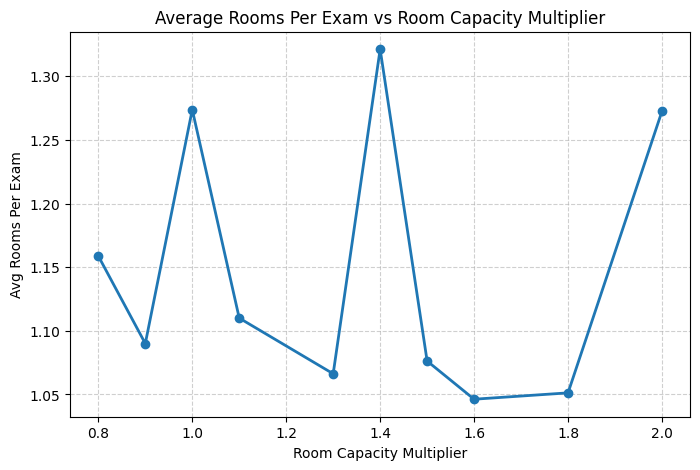

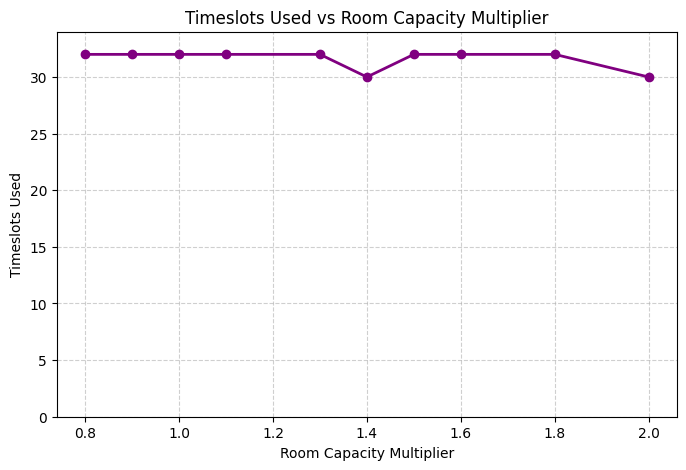

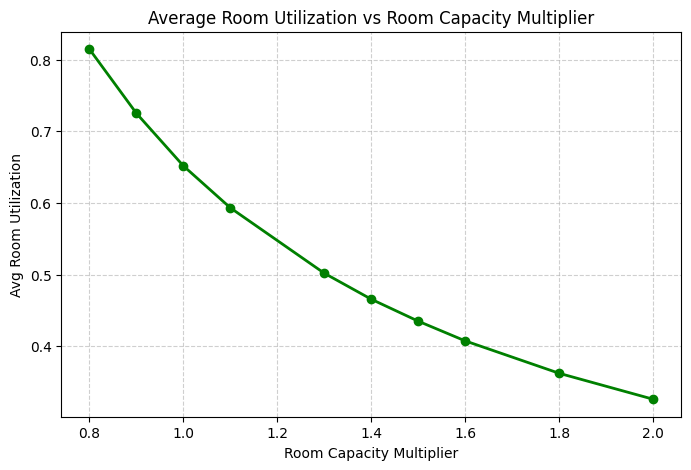

In [51]:
df_plot = df_cap1[df_cap1["feasible"] == True].copy()

# -----------------------------
# Plot 1: Avg Rooms Per Exam
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_rooms_per_exam"], marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -----------------------------
# Plot 2: Timeslots Used
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["timeslots_used"], marker='o', color="purple", linewidth=2)
plt.title("Timeslots Used vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Timeslots Used")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, max(df_plot["timeslots_used"])+2)
plt.show()

# -----------------------------
# Plot 3: Avg Room Utilization
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(df_plot["cap_multiplier"], df_plot["avg_room_utilization"], marker='o', color="green", linewidth=2)
plt.title("Average Room Utilization vs Room Capacity Multiplier")
plt.xlabel("Room Capacity Multiplier")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [52]:
def sensitivity_max_rooms():
    Ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    results = []

    for K in Ks:
        print(f"\n Running with max rooms K = {K}")
        out = run_model(K=K)
        results.append(out)

    df = pd.DataFrame(results)
    return df

df_K = sensitivity_max_rooms()
df_K


 Running with max rooms K = 1

 Running with max rooms K = 2

 Running with max rooms K = 3

 Running with max rooms K = 4

 Running with max rooms K = 5

 Running with max rooms K = 6

 Running with max rooms K = 7

 Running with max rooms K = 8

 Running with max rooms K = 9

 Running with max rooms K = 10


,feasible,status,runtime,cap_multiplier,K,enrollment_multiplier,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,False,3,81.688018,1.0,1,1.0,NaN,NaN,NaN
1,False,9,520.783594,1.0,2,1.0,NaN,NaN,NaN
2,True,OPTIMAL,201.817359,1.0,3,1.0,1.27375,32.0,0.651783
3,True,OPTIMAL,499.807128,1.0,4,1.0,1.10500,32.0,0.651783
4,True,OPTIMAL,206.696698,1.0,5,1.0,1.38375,32.0,0.651783
5,True,OPTIMAL,100.513974,1.0,6,1.0,1.49125,32.0,0.651783
6,True,OPTIMAL,436.705519,1.0,7,1.0,1.09375,32.0,0.651783
7,True,OPTIMAL,96.131678,1.0,8,1.0,1.49000,32.0,0.651783
8,True,OPTIMAL,372.576134,1.0,9,1.0,1.31125,32.0,0.651783
9,True,OPTIMAL,95.515106,1.0,10,1.0,1.46875,31.0,0.651783


When we vary the maximum number of rooms allowed per exam (K), we again observe that the model is **infeasible when (K = 1) or (K = 2)**. This is expected: several large exams in the Nottingham dataset have enrollments far exceeding the capacity of any single room, meaning they cannot be scheduled unless splitting is allowed. With (K < 3), the solver simply cannot allocate enough total seating space, even though the timeslot structure itself would otherwise permit a valid schedule.

Starting from **(K = 3)**, the model becomes feasible and remains feasible for all larger values of K up to 10. This confirms that at least three rooms are required for large exams, but allowing more than three rooms does not automatically improve feasibility or quality—splitting alone does not eliminate deeper structural bottlenecks in the timetable.

The **average rooms per exam fluctuates noticeably** across values of K (from approximately 1.09 to 1.49). This fluctuation is not monotonic because splitting behavior depends on a combination of interacting structural constraints, not just the numeric upper bound on the number of rooms. Specifically:

* **Duration constraints** restrict which timeslots each exam can occupy.
* **Same-day gap rules** limit valid slot combinations and often force exams into less flexible positions.
* **Coincidence groups** require some exams to run simultaneously, increasing room demand in specific slots.
* **Global timeslot capacity** limits how many total students can sit for exams in the same timeslot.

These factors jointly determine how many rooms an exam actually ends up using. As a result, increasing K allows more splitting *in theory*, but the solver will only use additional rooms when structural constraints force it to do so (e.g., at (K = 6, 7, 8, 10) where usage peaks around 1.49).

We also observe that **the number of timeslots used remains at 32** for all feasible K values *except* (K = 10), where the model manages to use **31 timeslots**. This indicates that very high splitting flexibility gives the solver slightly more freedom to compress large exams into fewer slots, but the improvement is marginal. Overall, the schedule remains tightly constrained by the **temporal structure** of the timetable—same-day gap requirements, group coincidences, and timeslot availability—not by the number of rooms.

Finally, **average room utilization stays exactly constant across all feasible values of K**. This is expected: increasing the maximum number of rooms per exam does not change total student enrollment, the physical capacities of rooms, or the number of students assigned to each timeslot. Therefore, the proportion of total room capacity that gets filled remains unchanged. K affects splitting flexibility but does not reduce or increase the fundamental demand per timeslot.

### **Overall, the experiment shows that:**

* **(K < 3)** leads to infeasibility because large exams cannot be seated.
* **(K \ge 3)** produces feasible schedules, but increasing K does **not** significantly change room utilization or reduce timeslot usage.
* The behavior of the schedule is governed primarily by **structural scheduling constraints**, not by the maximum splitting limit.
* Allowing very large K (e.g., 6–10) introduces oscillations in runtime and splitting behavior, but only marginally affects the final schedule.

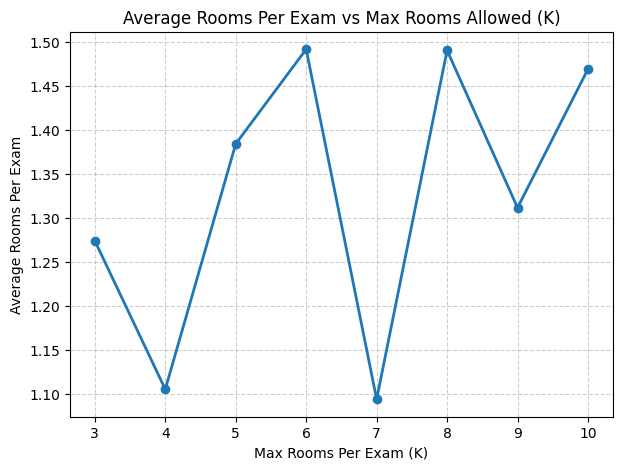

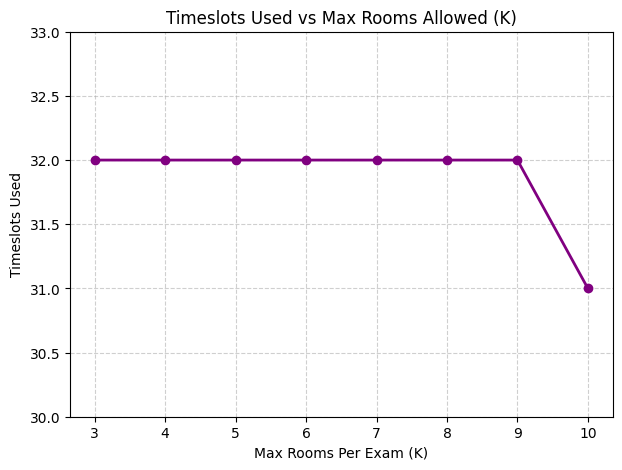

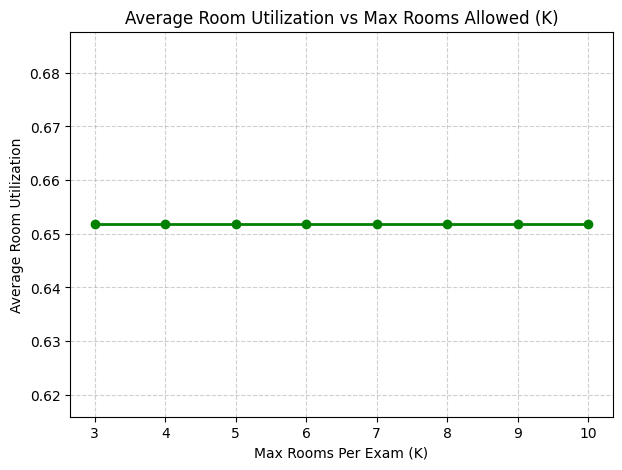

In [53]:
# Filter feasible solutions only
df_plot = df_K[df_K["feasible"] == True].copy()

# Plot 1: Avg Rooms Per Exam vs K
plt.figure(figsize=(7,5))
plt.plot(df_plot["K"], df_plot["avg_rooms_per_exam"],
         marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Max Rooms Allowed (K)")
plt.xlabel("Max Rooms Per Exam (K)")
plt.ylabel("Average Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 2: Timeslots Used vs K
plt.figure(figsize=(7,5))
plt.plot(df_plot["K"], df_plot["timeslots_used"],
         marker='o', linewidth=2, color="purple")
plt.title("Timeslots Used vs Max Rooms Allowed (K)")
plt.xlabel("Max Rooms Per Exam (K)")
plt.ylabel("Timeslots Used")
plt.ylim(min(df_plot["timeslots_used"])-1,
         max(df_plot["timeslots_used"])+1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot 3: Avg Room Utilization vs K
plt.figure(figsize=(7,5))
plt.plot(df_plot["K"], df_plot["avg_room_utilization"],
         marker='o', linewidth=2, color="green")
plt.title("Average Room Utilization vs Max Rooms Allowed (K)")
plt.xlabel("Max Rooms Per Exam (K)")
plt.ylabel("Average Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [54]:
def sensitivity_enrollment_uncertainty():
    multipliers = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
    results = []

    for m in multipliers:
        print(f"\n Running enrollment multiplier {m} ")
        out = run_model(enrollment_multiplier=m)
        results.append(out)

    df = pd.DataFrame(results)
    return df

df_enroll = sensitivity_enrollment_uncertainty()
df_enroll


 Running enrollment multiplier 0.3 

 Running enrollment multiplier 0.4 

 Running enrollment multiplier 0.5 

 Running enrollment multiplier 0.6 

 Running enrollment multiplier 0.7 

 Running enrollment multiplier 0.8 

 Running enrollment multiplier 0.9 

 Running enrollment multiplier 1.0 

 Running enrollment multiplier 1.1 

 Running enrollment multiplier 1.2 


,feasible,status,runtime,cap_multiplier,K,enrollment_multiplier,avg_rooms_per_exam,timeslots_used,avg_room_utilization
0,True,OPTIMAL,88.369826,1.0,3,0.3,1.03750,23.0,0.188631
1,True,OPTIMAL,116.390866,1.0,3,0.4,1.00625,28.0,0.254659
2,True,OPTIMAL,365.416282,1.0,3,0.5,1.01500,32.0,0.322067
3,True,OPTIMAL,291.493891,1.0,3,0.6,1.04375,32.0,0.384778
4,True,OPTIMAL,207.710800,1.0,3,0.7,1.09625,32.0,0.449099
5,True,OPTIMAL,195.001645,1.0,3,0.8,1.18250,32.0,0.515050
6,True,OPTIMAL,421.755776,1.0,3,0.9,1.05375,32.0,0.579352
7,True,OPTIMAL,192.637883,1.0,3,1.0,1.27375,32.0,0.651783
8,True,OPTIMAL,514.422260,1.0,3,1.1,1.15750,32.0,0.710257
9,False,9,517.149028,1.0,3,1.2,NaN,NaN,NaN


When we vary the enrollment multiplier, the model remains feasible for multipliers from **0.3 through 1.1**, but becomes **infeasible at 1.2**. This demonstrates that the exam timetabling system is robust to substantial reductions in enrollment and can tolerate moderate increases. However, once total enrollment grows by about **20%**, the combined room capacity across available rooms becomes insufficient—even with exam splitting. At this point, no assignment of rooms and timeslots can simultaneously satisfy room capacity constraints, global timeslot capacity, and the structural scheduling rules, causing the solver to fail.

The **average rooms per exam** increases gradually as enrollment increases, as expected. Larger exams require greater splitting to fit inside room capacity limits. However, this increase is **not perfectly smooth**, because splitting behavior is shaped by interactions among structural constraints:

* **Duration constraints**, which restrict feasible timeslots
* **Same-day gap rules**, which block many slot combinations
* **Coincidence groups**, which force certain exams to occur together
* **Global timeslot capacity**, which limits how many students can be scheduled simultaneously

These constraints determine how large exams can be placed and how many rooms must be allocated to them. For example, the model uses fewer rooms at an enrollment multiplier of 0.9 than at 0.8 or 1.0 because the solver finds a configuration that satisfies the gap and coincidence rules more efficiently. Conversely, rooms per exam rise at 1.1, reflecting increased pressure on room capacity.

One notable pattern in the new results is that **timeslots used are not constant at lower enrollment levels**. When enrollments drop significantly (e.g., multiplier = 0.3 or 0.4), the solver can compress the schedule into **23 or 28 timeslots**, instead of the usual 32. This occurs because smaller exams reduce congestion, allowing more flexibility in respecting same-day gap constraints. However, once enrollment returns to near-normal levels (multipliers 0.5 and above), the schedule stabilizes at **32 timeslots**, showing that the temporal structure—not room capacity—is the true bottleneck.

The **average room utilization increases smoothly** as enrollment increases. Since room capacity remains constant while student counts rise, utilization grows proportionally. At multiplier 1.2, utilization would exceed feasible levels, directly corresponding to the observed infeasibility.

Finally, runtime fluctuates substantially and non-monotonically across enrollment multipliers. Lower enrollment makes some constraints easier to satisfy (runtime 88–200 seconds), whereas intermediate multipliers (0.5–0.9) produce more combinatorial complexity due to multiple competing feasible choices. Very high multipliers (1.1) again increase runtime as room capacities start to become binding.

# **Overall, this sensitivity analysis reveals that:**

* The model is highly flexible at low enrollments and can compress the schedule significantly.
* Timeslot structure and gap rules—not room capacity—are the primary limiting factors at normal enrollment levels.
* Moderate increases in enrollment push more exams to split across rooms.
* Once enrollment increases by around **20%**, room and timeslot capacities become jointly insufficient, leading to infeasibility.
* Runtime reflects the complexity of constraint interactions, rather than enrollment size alone.

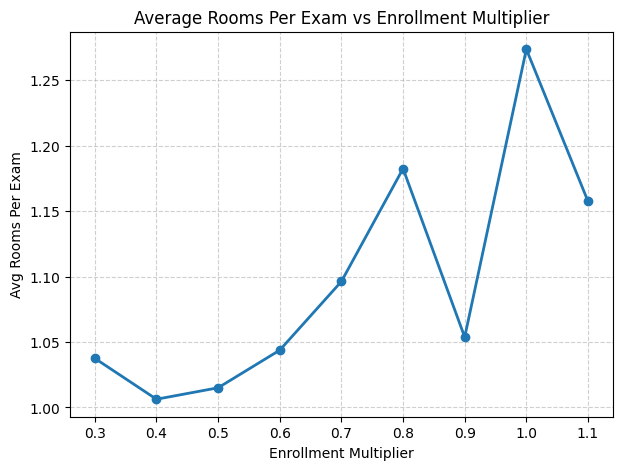

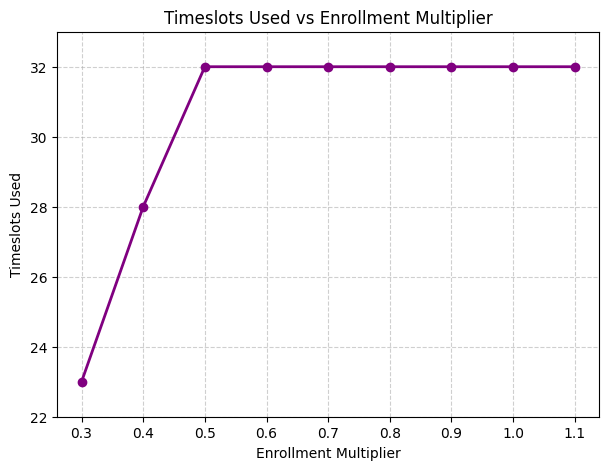

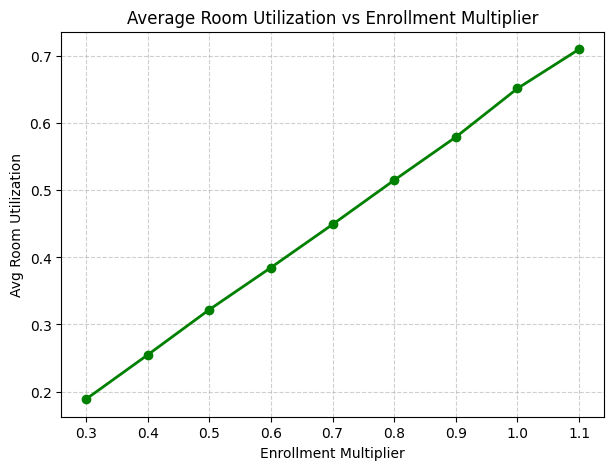

In [55]:
# Filter feasible rows only
df_plot = df_enroll[df_enroll["feasible"] == True].copy()

# --------------------------------------
# Plot 1: Avg Rooms Per Exam vs Enrollment Multiplier
# --------------------------------------
plt.figure(figsize=(7,5))
plt.plot(df_plot["enrollment_multiplier"], df_plot["avg_rooms_per_exam"],
         marker='o', linewidth=2)
plt.title("Average Rooms Per Exam vs Enrollment Multiplier")
plt.xlabel("Enrollment Multiplier")
plt.ylabel("Avg Rooms Per Exam")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --------------------------------------
# Plot 2: Timeslots Used vs Enrollment Multiplier
# --------------------------------------
plt.figure(figsize=(7,5))
plt.plot(df_plot["enrollment_multiplier"], df_plot["timeslots_used"],
         marker='o', linewidth=2, color="purple")
plt.title("Timeslots Used vs Enrollment Multiplier")
plt.xlabel("Enrollment Multiplier")
plt.ylabel("Timeslots Used")
plt.ylim(min(df_plot["timeslots_used"])-1,
         max(df_plot["timeslots_used"])+1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --------------------------------------
# Plot 3: Average Room Utilization vs Enrollment Multiplier
# --------------------------------------
plt.figure(figsize=(7,5))
plt.plot(df_plot["enrollment_multiplier"], df_plot["avg_room_utilization"],
         marker='o', linewidth=2, color="green")
plt.title("Average Room Utilization vs Enrollment Multiplier")
plt.xlabel("Enrollment Multiplier")
plt.ylabel("Avg Room Utilization")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Model 4: Minimizing same day student conflicts

### Additional Set
$$
D: \text{ set of days}
$$

Each timeslot $t \in T$ belongs to exactly one day denoted $\text{day}(t) \in D$.

### New decision variable
$$
c_{s,i,j} =
\begin{cases}
1 & \text{if student } s \text{ has exams } i \text{ and } j \text{ on the same day}, \\
0 & \text{otherwise}.
\end{cases}
$$

(Defined only for pairs $i < j$ where student $s$ is enrolled in both.)

## Constraints

### 7. Define same-day conflict indicator
For all students $s$, for all exam pairs $(i < j \in E_s)$:

$$
c_{s,i,j} \geq \sum_{t:day(t)=d} x_{i,t} + \sum_{t:day(t)=d}x x_{j,t} -1 
\quad \forall d \in D
$$

(This forces $(c_{s,i,j} = 1)$ if the two exams are scheduled on the same day.)

## Objective: Minimize total same-day conflicts

$$
\min \sum_{s \in S} \sum_{i < j \in E_s} c_{s,i,j}
$$

### Notes
- Model 3 **keeps all constraints from Model 1 and Model 2** (feasibility).  
- Model 3 only **adds conflict indicators and minimization objective**.

## Model 5: Minimizing consecutive or overnight exam conflicts

### Additional Definition
Each timeslot $t \in T$ has an associated ordering index $\text{ord}(t)$ such that \( \text{ord}(t+1) \) is the next available timeslot.

A pair of exams is considered consecutive for a student if they occur in timeslots $t$ and $t'$ with $\text{ord}(t') = \text{ord}(t) + 1$.

### New decision variable
$$
o_{s,i,j} =
\begin{cases}
1 & \text{if student } s \text{ has exams } i \text{ and } j \text{ in consecutive timeslots}, \\
0 & \text{otherwise}.
\end{cases}
$$

# New constraints for model 5

### 8. Consecutive timeslot conflict indicator
For all students $s$, exams $i < j \in E_s$, and all consecutive slots $t, t'$:

$$
o_{s,i,j} \ge x_{i,t} + x_{j,t'} - 1
\qquad \forall s,\, \forall i<j \in E_s,\, \forall (t,t') \text{ such that } \text{ord}(t') = \text{ord}(t)+1.
$$

Symmetrically, the reverse order is also a conflict:

$$
o_{s,i,j} \ge x_{i,t'} + x_{j,t} - 1
\qquad \forall s,\, \forall i<j \in E_s,\, \forall (t,t') \text{ consecutive}.
$$

## Objective for model 5
Minimize the number of consecutive or overnight exam conflicts:

$$
\min \sum_{s \in S} \sum_{i<j \in E_s} o_{s,i,j}
$$

## Model 6: Institutional constraints and priority scheduling


Model 6 extends the previous models by incorporating institutional, departmental, and logistical rules extracted from the University of Nottingham dataset. No new decision variables are added. All constraints below apply to the existing variables:


$$
x_{i,t} =
\begin{cases}
1 & \text{if exam $i$ is scheduled in timeslot $t$,} \\
0 & \text{otherwise,}
\end{cases}
\qquad
y_{i,r} =
\begin{cases}
1 & \text{if exam $i$ is assigned room $r$,} \\
0 & \text{otherwise.}
\end{cases}
$$


Let:
$A_i \subseteq T$ be allowed timeslots for exam $i$.


$R_i \subseteq R$ be allowed rooms for exam $i$.


$P_i$ = priority weight for earliness.


$\mathrm{ord}(t)$ be chronological index of timeslot $t$.


$\mathcal{G}$ be set of standard coincidence groups.


$\mathcal{G}^{\mathrm{seq}}$ be special coincidence groups requiring ordered execution within a single long timeslot.


$\mathcal{G}^{\mathrm{one}}$ be coincidence groups required to share exactly one room and exclude all other exams.


$\mathcal{S}$ be set of exam pairs $(i,j)$ where $i$ must occur before $j$.


$\mathcal{F}$ be set of forbidden room–timeslot pairs $(r,t)$.


$\mathcal{D}^{\mathrm{AM}},\ \mathcal{D}^{\mathrm{PM}}$ be AM-only or PM-only exam sets.


$\mathcal{X}$ be set of spread-out exam groups.


$\mathcal{R}^{\mathrm{comb}}_i$ be pairs of rooms $\,(r,r')$ that must be simultaneously assigned to exam $i$.


## Constraint


### 1. Allowed timeslot constraints


$$
x_{i,t} = 0 \qquad \forall i \in C,\ \forall t \notin A_i.
$$


This encodes restrictions such as:


$K1AHWAE2$: allowed only in AM slots.


$V13101E1$: allowed only in Thursday PM slots.


Exams restricted to the calendar window Jan 23--24.




### 2. Allowed room constraints


$$
y_{i,r} = 0 \qquad \forall i \in C,\ \forall r \notin R_i.
$$


Examples encoded in $R_i$ include:


ART exams restricted to **ART-LECTURE** or **ART-SEMINAR** rooms.


Chemistry exams requiring **CHEMISTRY** laboratories.


Architecture exams requiring **ARCHTCT-LR1**.


$AA3008E1$ requiring the special two-phase assignment (see sequencing constraints below).


### 3. Standard coincidence constraints


For every coincidence group $G \in \mathcal{G}$,all exams must occur in the same timeslot:
$$
x_{i,t} = x_{j,t}
\qquad \forall G\in\mathcal{G},\ \forall i,j \in G,\ \forall t\in T.
$$


These include groups such as:
$$
\{ \text{LK44FAE1, LK44GAE1, LK44SAE1} \},
\quad
\{ \text{M11341E1, M11345E1} \},
\quad \text{etc.}
$$


### 4. Special ``one-after-the-other'' coincidence groups


For any group $G \in \mathcal{G}^{\mathrm{seq}}$ 
(e.g.\ $\{\text{C13563E1}, \text{C13571E1}, \text{C13572E1}\}$),
all exams must share the same timeslot:
$$
x_{i,t} = x_{j,t}
\qquad \forall G\in\mathcal{G}^{\mathrm{seq}},\ \forall i,j\in G,\ \forall t.
$$


Additionally, exams that must occur in order (back-to-back within the same slot)
satisfy:
$$
\mathrm{orderWithinSlot}(i) < \mathrm{orderWithinSlot}(j)
\qquad \forall (i,j) \in \mathcal{G}^{\mathrm{seq}}_{\mathrm{ordered}}.
$$


(If the model treats timeslots as atomic, this may be relaxed.)


### 5. One-room-only coincidence groups


For groups $G \in \mathcal{G}^{\mathrm{one}}$
(e.g.\ $\{\text{H22C20E1}, \text{H23C20E1}, \text{H24C20E1}, \text{H23CEOE1}\}$):


$$
x_{i,t} = x_{j,t}
\qquad \forall i,j\in G,\ \forall t.
$$


All exams must share exactly one room:
$$
y_{i,r} = y_{j,r}
\qquad \forall i,j\in G,\ \forall r\in R.
$$


No other exam may use that room:
$$
\sum_{k \notin G} y_{k,r} = 0
\qquad \forall r \text{ with } y_{i,r} = 1.
$$


### 6. Sequencing constraints (before/after)


For each ordered pair $(i,j) \in \mathcal{S}$:
$$
\sum_{t\in T} \mathrm{ord}(t)\, x_{i,t}
<
\sum_{t\in T} \mathrm{ord}(t)\, x_{j,t}.
$$


Examples include:
$$
\text{F13P03E1} \prec \text{F13X03E1},
\qquad
\text{F13P05E1} \prec \text{F13X04E1},
\qquad
\text{H3BFM2E1} \text{ immediately before } \text{H3BFM2E2}.
$$


### 7. Room unavailability and forbidden pairs


For each forbidden room--timeslot pair $(r,t)\in\mathcal{F}$,
such as TRENT-B46 on Friday AM:
$$
y_{i,r} + x_{i,t} \le 1
\qquad \forall i\in C.
$$


\subsubsection*{8. AM-only and PM-only exam constraints}


$$
x_{i,t} = 0
\qquad \forall i \in \mathcal{D}^{\mathrm{AM}},\ \forall t \notin \mathrm{AM}.
$$


$$
x_{i,t} = 0
\qquad \forall i \in \mathcal{D}^{\mathrm{PM}},\ \forall t \notin \mathrm{PM}.
$$


### 9. Spread-out constraints


For each spread-out group $X\in\mathcal{X}$,
exams must not occur too close together. For every $i,j\in X$:
$$
\lvert\, \mathrm{ord}(t_i) - \mathrm{ord}(t_j) \,\rvert \ge \Delta_X,
$$
where
$$
t_i = \sum_{t\in T} \mathrm{ord}(t)\, x_{i,t}.
$$


Groups include:
$$
\{\text{Q33211E1},\ \text{Q33307E1},\ \text{Q33308E1}\},
\qquad
\{\text{B12301E1},\text{B12302E1},\text{B12303E1},\text{B12320E1}\},
\quad \text{etc.}
$$


### 10. Combined-room requirements


If exam $i$ must use both rooms $r$ and $r'$ simultaneously:
$$
y_{i,r} = y_{i,r'}
\qquad \forall (r,r') \in \mathcal{R}^{\mathrm{comb}}_i.
$$


This includes exams requiring POPE-A13 and POPE-A14 jointly.


### 11. Earliness penalty


Define:
$$
\mathrm{penalty}_i
=
\sum_{t\in T} P_i \cdot \mathrm{ord}(t) \cdot x_{i,t}.
$$


### 12.  Model 5 Objective


$$
\min
\left(
\alpha \sum_{s,i,j} c_{s,i,j}
\;+\;
\beta \sum_{s,i,j} o_{s,i,j}
\;+\;
\gamma \sum_{i\in C} \mathrm{penalty}_i
\right).
$$


Where:


$c_{s,i,j}$ = consecutive-conflict indicator,


$o_{s,i,j}$ = same-day conflict indicator,


$\alpha,\beta,\gamma$ = user-defined weights.